In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
df = pd.read_csv('vehicles_prep.csv')
df.head()


,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
0,33590,2014.0,gmc,good,8 cylinders,gas,57923,clean,other,4wd,pickup,white,al
1,22590,2010.0,chevrolet,good,8 cylinders,gas,71229,clean,other,4wd,pickup,blue,al
2,39590,2020.0,chevrolet,good,8 cylinders,gas,19160,clean,other,4wd,pickup,red,al
3,30990,2017.0,toyota,good,8 cylinders,gas,41124,clean,other,fwd,pickup,red,al
4,15000,2013.0,ford,excellent,6 cylinders,gas,128000,clean,automatic,rwd,truck,black,al


In [3]:
# 1) Agrupar categorías raras: top 10 + "Other"
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    top10 = df[col].value_counts().nlargest(10).index
    df[col] = df[col].where(df[col].isin(top10), other='Other')

# 2) Prepara X/y y split
X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3) ColumnTransformer con sparse encoding
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
preprocessor = ColumnTransformer([
    ('num', Pipeline([
         ('imputer', SimpleImputer(strategy='mean')),
         ('scaler', StandardScaler())
    ]), num_cols),
    ('cat', Pipeline([
         ('imputer', SimpleImputer(strategy='most_frequent')),
         ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
    ]), cat_cols)
], sparse_threshold=0.1)

# 4) Muestra para buscar α
X_sub, _, y_sub, _ = train_test_split(
    X_train, y_train, train_size=50000, random_state=42
)
X_sub_trans = preprocessor.fit_transform(X_sub)

alphas = np.logspace(0, 3, 10)
best_alpha, best_mse = None, np.inf
for a in alphas:
    m = Ridge(alpha=a).fit(X_sub_trans, y_sub)
    mse = mean_squared_error(y_sub, m.predict(X_sub_trans))
    if mse < best_mse:
        best_mse, best_alpha = mse, a

print("α candidato:", best_alpha)

# 5) Entrena Ridge final con ese α
model = Pipeline([
    ('preproc', preprocessor),
    ('ridge', Ridge(alpha=best_alpha*2))   # puedes ajustar factor para asegurar fuerte regularización
])
model.fit(X_train, y_train)

y_tr = model.predict(X_train)
y_te = model.predict(X_test)
r2_tr = r2_score(y_train, y_tr)
r2_te = r2_score(y_test, y_te)
overf = (r2_tr - r2_te)/abs(r2_tr)*100

mse_tr = mean_squared_error(y_train, y_tr)
mse_te = mean_squared_error(y_test, y_te)

rmse_tr = np.sqrt(mse_tr)
rmse_te = np.sqrt(mse_te)

print(f"MSE Train: {mse_tr:.2f}")
print(f"MSE Test:  {mse_te:.2f}")
print(f"RMSE Train: {rmse_tr:.2f}")
print(f"RMSE Test:  {rmse_te:.2f}")

print(f"R² Train: {r2_tr:.4f}")
print(f"R² Test:  {r2_te:.4f}")
print(f"Overfitting: {overf:.2f}%")

α candidato: 1.0
MSE Train: 83212448.87
MSE Test:  84448204.81
RMSE Train: 9122.09
RMSE Test:  9189.57
R² Train: 0.5876
R² Test:  0.5835
Overfitting: 0.70%


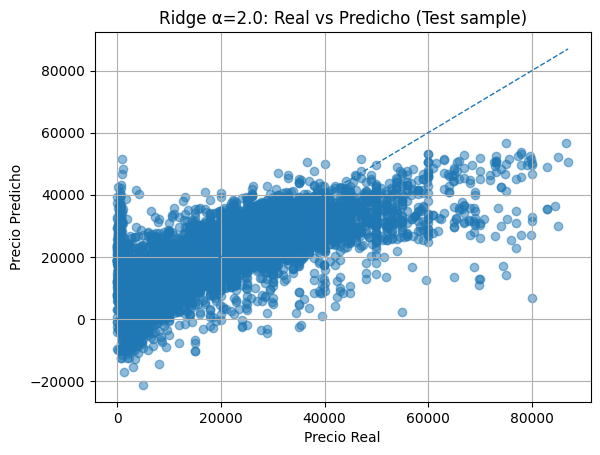

In [4]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Carga y agrupa categorías raras
df = pd.read_csv('vehicles_prep.csv')
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    top10 = df[col].value_counts().nlargest(10).index
    df[col] = df[col].where(df[col].isin(top10), other='Other')

# Split inicial
X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Muestras para entrenamiento & test (para gráfico)
X_train_s = X_train.sample(50000, random_state=42)
y_train_s = y_train.loc[X_train_s.index]
X_test_s  = X_test.sample(10000, random_state=42)
y_test_s  = y_test.loc[X_test_s.index]

# Preprocesamiento
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
preprocessor = ColumnTransformer([
    ('num', Pipeline([('imputer', SimpleImputer(strategy='mean')),
                      ('scaler', StandardScaler())]), num_cols),
    ('cat', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                      ('onehot', OneHotEncoder(handle_unknown='ignore'))]), cat_cols)
], sparse_threshold=0)

# Modelo Ridge con α=2.0
model = Pipeline([
    ('preproc', preprocessor),
    ('ridge', Ridge(alpha=2.0))
])
model.fit(X_train_s, y_train_s)

# Predicciones y R² sobre la muestra
y_tr_s = model.predict(X_train_s)
y_te_s = model.predict(X_test_s)
r2_tr_s = r2_score(y_train_s, y_tr_s)
r2_te_s = r2_score(y_test_s, y_te_s)

# Gráfica 1: Real vs Predicho (Test sample)
plt.figure()
plt.scatter(y_test_s, y_te_s, alpha=0.5)
plt.plot([y_test_s.min(), y_test_s.max()],
         [y_test_s.min(), y_test_s.max()],
         '--', linewidth=1)
plt.xlabel("Precio Real")
plt.ylabel("Precio Predicho")
plt.title("Ridge α=2.0: Real vs Predicho (Test sample)")
plt.grid(True)
plt.show()

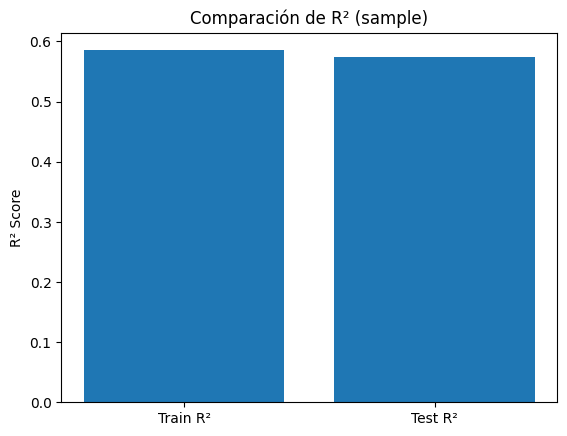

In [5]:
# Gráfica 2: Comparación de R² (sample)
plt.figure()
plt.bar(["Train R²", "Test R²"], [r2_tr_s, r2_te_s])
plt.ylabel("R² Score")
plt.title("Comparación de R² (sample)")
plt.show()

In [6]:
data=pd.read_csv("vehicles_prep.csv")
data

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
0,33590,2014.0,gmc,good,8 cylinders,gas,57923,clean,other,4wd,pickup,white,al
1,22590,2010.0,chevrolet,good,8 cylinders,gas,71229,clean,other,4wd,pickup,blue,al
2,39590,2020.0,chevrolet,good,8 cylinders,gas,19160,clean,other,4wd,pickup,red,al
3,30990,2017.0,toyota,good,8 cylinders,gas,41124,clean,other,fwd,pickup,red,al
4,15000,2013.0,ford,excellent,6 cylinders,gas,128000,clean,automatic,rwd,truck,black,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...
375170,23590,2019.0,nissan,good,6 cylinders,gas,32226,clean,other,fwd,sedan,grey,wy
375171,30590,2020.0,volvo,good,4 cylinders,gas,12029,clean,other,fwd,sedan,red,wy
375172,34990,2020.0,cadillac,good,6 cylinders,diesel,4174,clean,other,4wd,hatchback,white,wy
375173,28990,2018.0,lexus,good,6 cylinders,gas,30112,clean,other,fwd,sedan,silver,wy


In [7]:
data.describe(include="all")

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
count,375175.000000,375175.000000,375174,375175,375175,375175,375175.000000,375175,375175,375175,375175,375175,375175
unique,NaN,NaN,42,6,8,5,NaN,6,3,3,13,12,51
top,NaN,NaN,ford,excellent,6 cylinders,gas,NaN,clean,automatic,4wd,sedan,white,ca
freq,NaN,NaN,64331,232106,157934,319357,NaN,362655,295300,175646,114373,97669,43232
mean,18680.958729,2011.577450,NaN,NaN,NaN,NaN,92288.583821,NaN,NaN,NaN,NaN,NaN,NaN
std,14212.094236,7.694792,NaN,NaN,NaN,NaN,62742.648306,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,1975.858005,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,7400.000000,2008.000000,NaN,NaN,NaN,NaN,38594.500000,NaN,NaN,NaN,NaN,NaN,NaN
50%,15491.000000,2013.000000,NaN,NaN,NaN,NaN,86592.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,27590.000000,2017.000000,NaN,NaN,NaN,NaN,134558.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375175 entries, 0 to 375174
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         375175 non-null  int64  
 1   year          375175 non-null  float64
 2   manufacturer  375174 non-null  object 
 3   condition     375175 non-null  object 
 4   cylinders     375175 non-null  object 
 5   fuel          375175 non-null  object 
 6   odometer      375175 non-null  int64  
 7   title_status  375175 non-null  object 
 8   transmission  375175 non-null  object 
 9   drive         375175 non-null  object 
 10  type          375175 non-null  object 
 11  paint_color   375175 non-null  object 
 12  state         375175 non-null  object 
dtypes: float64(1), int64(2), object(10)
memory usage: 37.2+ MB


In [9]:
data= data[data['cylinders'] != 'other']


In [10]:
print(data["cylinders"].unique())

['8 cylinders' '6 cylinders' '4 cylinders' '5 cylinders' '10 cylinders'
 '3 cylinders' '12 cylinders']


In [11]:
# Eliminar la palabra "cylinders" y convertir a int
data['cylinders'] = data['cylinders'].str.replace(' cylinders', '').astype(int)

# Verificar que la conversión fue exitosa
print(data['cylinders'].dtype)  # Debe ser 'int'


int64


<ipython-input-11-8752abe3c58a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cylinders'] = data['cylinders'].str.replace(' cylinders', '').astype(int)


In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 1. Separar variables predictoras y objetivo
X = data.drop('price', axis=1)
y = data['price']

# 2. Codificación One-Hot para variables categóricas
X_encoded = pd.get_dummies(X, drop_first=True)

# 3. División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# 4. Escalado de variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Entrenamiento del modelo de regresión lineal
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# 6. Predicciones y evaluación
y_pred = model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"🔍 Evaluación del modelo de Regresión Lineal:")
print(f" - RMSE: {rmse:.2f}")
print(f" - R²: {r2:.2f}")


🔍 Evaluación del modelo de Regresión Lineal:
 - RMSE: 8928.23
 - R²: 0.61


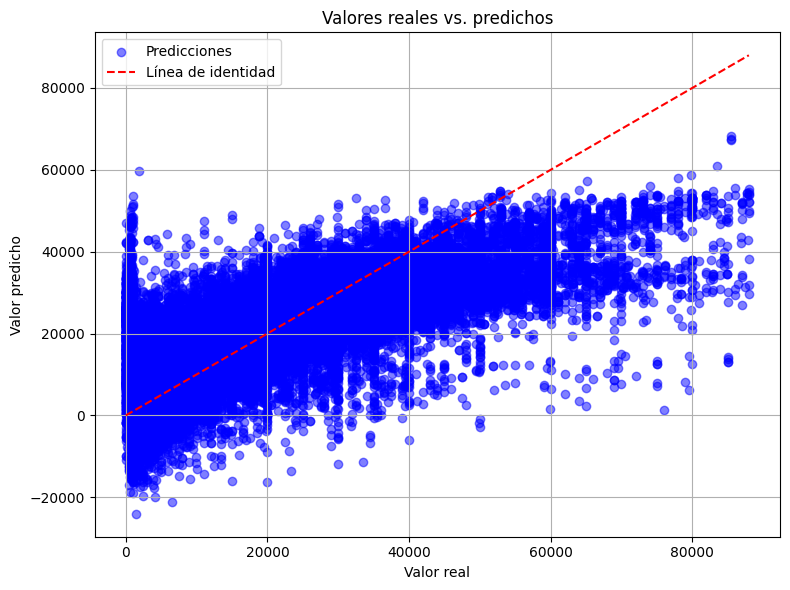

In [13]:
import matplotlib.pyplot as plt

# Gráfico de dispersión de valores reales vs. predichos
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label="Predicciones")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Línea de identidad")
plt.title('Valores reales vs. predichos')
plt.xlabel('Valor real')
plt.ylabel('Valor predicho')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#Vamos a intentar mejor el modelo

🔍 Evaluación del modelo con log(price):
 - RMSE: 9786.46
 - R²: 0.53


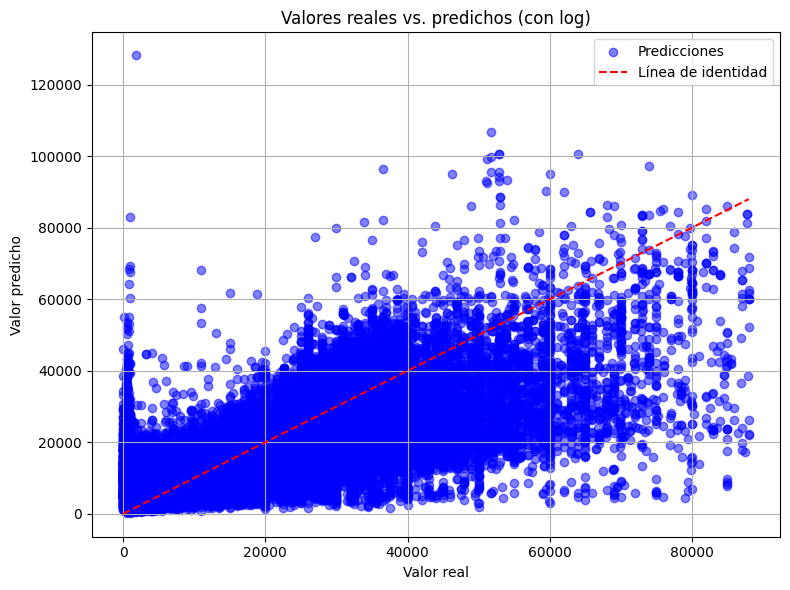

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Separar variables predictoras y objetivo
X = data.drop('price', axis=1)
y = data['price']

# 2. Codificación One-Hot para variables categóricas (si no está hecho ya)
X_encoded = pd.get_dummies(X, drop_first=True)

# 3. Transformar y con logaritmo (log1p para manejar ceros)
y_log = np.log1p(y)

# 4. División en entrenamiento y prueba
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X_encoded, y_log, test_size=0.2, random_state=42
)

# 5. Escalado de variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Entrenamiento del modelo
model = LinearRegression()
model.fit(X_train_scaled, y_train_log)

# 7. Predicciones en escala logarítmica y destransformación
y_pred_log = model.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)       # volver a escala original
y_test = np.expm1(y_test_log)       # volver a escala original para comparar

# 8. Evaluación
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("🔍 Evaluación del modelo con log(price):")
print(f" - RMSE: {rmse:.2f}")
print(f" - R²: {r2:.2f}")

# 9. Gráfico real vs. predicho
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label="Predicciones")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)],
         color='red', linestyle='--', label="Línea de identidad")
plt.title('Valores reales vs. predichos (con log)')
plt.xlabel('Valor real')
plt.ylabel('Valor predicho')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


🌲 Random Forest (sin log):
 - RMSE: 5061.80
 - R²: 0.87

🌲 Random Forest (con log):
 - RMSE: 5862.76
 - R²: 0.83


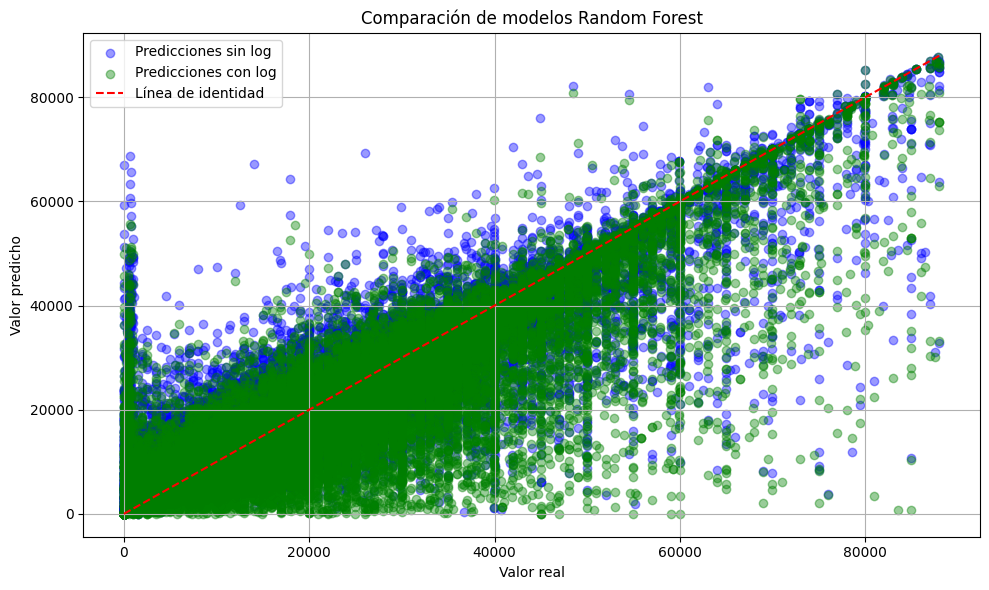

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Separar variables predictoras y objetivo
X = data.drop('price', axis=1)
y = data['price']

# 2. One-Hot Encoding (si no está hecho aún)
X_encoded = pd.get_dummies(X, drop_first=True)

# 3. División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# 4. Escalado de variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ========== MODELO 1: Random Forest SIN transformación log ==========
rf_plain = RandomForestRegressor(n_estimators=100, random_state=42)
rf_plain.fit(X_train_scaled, y_train)

y_pred_plain = rf_plain.predict(X_test_scaled)

rmse_plain = np.sqrt(mean_squared_error(y_test, y_pred_plain))
r2_plain = r2_score(y_test, y_pred_plain)

print("🌲 Random Forest (sin log):")
print(f" - RMSE: {rmse_plain:.2f}")
print(f" - R²: {r2_plain:.2f}")

# ========== MODELO 2: Random Forest CON log(price) ==========
y_log = np.log1p(y)  # transformación logarítmica
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

rf_log = RandomForestRegressor(n_estimators=100, random_state=42)
rf_log.fit(X_train_scaled, y_train_log)

y_pred_log = rf_log.predict(X_test_scaled)
y_pred_log_inverse = np.expm1(y_pred_log)  # destransformación
y_test_inverse = np.expm1(y_test_log)

rmse_log = np.sqrt(mean_squared_error(y_test_inverse, y_pred_log_inverse))
r2_log = r2_score(y_test_inverse, y_pred_log_inverse)

print("\n🌲 Random Forest (con log):")
print(f" - RMSE: {rmse_log:.2f}")
print(f" - R²: {r2_log:.2f}")

# ========== Gráfico de valores reales vs. predichos ==========
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_plain, alpha=0.4, label="Predicciones sin log", color='blue')
plt.scatter(y_test, y_pred_log_inverse, alpha=0.4, label="Predicciones con log", color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Línea de identidad")
plt.xlabel("Valor real")
plt.ylabel("Valor predicho")
plt.title("Comparación de modelos Random Forest")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_log_error, r2_score

# ========== MÉTRICAS para el modelo sin transformación log ==========

# Error absoluto medio (MAE)
mae_plain = mean_absolute_error(y_test, y_pred_plain)

# Error cuadrático medio (RMSE) ya calculado anteriormente
rmse_plain = np.sqrt(mean_squared_error(y_test, y_pred_plain))

# Coeficiente de determinación ajustado (R² ajustado)
n = len(y_test)  # número de observaciones
p = X_test_scaled.shape[1]  # número de predictores
r2_adj_plain = 1 - (1 - r2_plain) * (n - 1) / (n - p - 1)

# ========== MÉTRICAS para el modelo con log transformación ==========

# Error absoluto medio (MAE) con log
mae_log = mean_absolute_error(y_test_inverse, y_pred_log_inverse)

# Error cuadrático medio (RMSE) con log ya calculado anteriormente
rmse_log = np.sqrt(mean_squared_error(y_test_inverse, y_pred_log_inverse))

# Coeficiente de determinación ajustado (R² ajustado) con log
r2_adj_log = 1 - (1 - r2_log) * (n - 1) / (n - p - 1)

# Error cuadrático medio logarítmico (MSLE)
msle_log = mean_squared_log_error(y_test_inverse, y_pred_log_inverse)

# ========== Resultados y Métricas ==========

# Resultados para el modelo sin log
print("🌲 Random Forest (sin log):")
print(f" - RMSE: {rmse_plain:.2f}")
print(f" - R²: {r2_plain:.2f}")
print(f" - R² Ajustado: {r2_adj_plain:.2f}")
print(f" - MAE: {mae_plain:.2f}")
print(f" - MSLE: {msle_log:.2f}")

# Resultados para el modelo con log
print("\n🌲 Random Forest (con log):")
print(f" - RMSE: {rmse_log:.2f}")
print(f" - R²: {r2_log:.2f}")
print(f" - R² Ajustado: {r2_adj_log:.2f}")
print(f" - MAE: {mae_log:.2f}")
print(f" - MSLE: {msle_log:.2f}")


🌲 Random Forest (sin log):
 - RMSE: 5061.80
 - R²: 0.87
 - R² Ajustado: 0.87
 - MAE: 2401.25
 - MSLE: 0.45

🌲 Random Forest (con log):
 - RMSE: 5862.76
 - R²: 0.83
 - R² Ajustado: 0.83
 - MAE: 2741.95
 - MSLE: 0.45


In [19]:
# ================== Cálculo de MSE y RMSE para entrenamiento y prueba ==================

# Cálculo de MSE (Mean Squared Error) para entrenamiento y prueba
mse_train_plain = mean_squared_error(y_train, y_pred_train_plain)
mse_test_plain = mean_squared_error(y_test, y_pred_plain)

# Cálculo de RMSE (Root Mean Squared Error) para entrenamiento y prueba
rmse_train_plain = np.sqrt(mse_train_plain)
rmse_test_plain = np.sqrt(mse_test_plain)

# ================== Cálculo de R² para entrenamiento y prueba ==================
r2_train_plain = r2_score(y_train, y_pred_train_plain)
r2_test_plain = r2_score(y_test, y_pred_plain)

# ================== Detección de Overfitting ==================
# Calculando el Overfitting en términos relativos
overfitting_percentage = (rmse_test_plain - rmse_train_plain) / rmse_train_plain * 100

# ================== Imprimir los resultados ==================

print(f"MSE Train: {mse_train_plain:.2f}")
print(f"MSE Test:  {mse_test_plain:.2f}")
print(f"RMSE Train: {rmse_train_plain:.2f}")
print(f"RMSE Test:  {rmse_test_plain:.2f}")
print(f"R² Train: {r2_train_plain:.4f}")
print(f"R² Test:  {r2_test_plain:.4f}")
print(f"Overfitting: {overfitting_percentage:.2f}%")


MSE Train: 3820829.04
MSE Test:  25621796.40
RMSE Train: 1954.69
RMSE Test:  5061.80
R² Train: 0.9810
R² Test:  0.8739
Overfitting: 158.96%


In [20]:
# Random Forest con parámetros más restrictivos
rf_tuned = RandomForestRegressor(n_estimators=50, max_depth=10, min_samples_split=10, random_state=42)

# Entrenar el modelo ajustado
rf_tuned.fit(X_train_scaled, y_train)

# Hacer predicciones
y_pred_train_tuned = rf_tuned.predict(X_train_scaled)
y_pred_test_tuned = rf_tuned.predict(X_test_scaled)

# Cálculo de métricas
mse_train_tuned = mean_squared_error(y_train, y_pred_train_tuned)
mse_test_tuned = mean_squared_error(y_test, y_pred_test_tuned)
rmse_train_tuned = np.sqrt(mse_train_tuned)
rmse_test_tuned = np.sqrt(mse_test_tuned)
r2_train_tuned = r2_score(y_train, y_pred_train_tuned)
r2_test_tuned = r2_score(y_test, y_pred_test_tuned)

# Mostrar resultados
print(f"MSE Train (tuned): {mse_train_tuned:.2f}")
print(f"MSE Test (tuned): {mse_test_tuned:.2f}")
print(f"RMSE Train (tuned): {rmse_train_tuned:.2f}")
print(f"RMSE Test (tuned): {rmse_test_tuned:.2f}")
print(f"R² Train (tuned): {r2_train_tuned:.4f}")
print(f"R² Test (tuned): {r2_test_tuned:.4f}")


MSE Train (tuned): 53833416.39
MSE Test (tuned): 55340577.12
RMSE Train (tuned): 7337.13
RMSE Test (tuned): 7439.12
R² Train (tuned): 0.7324
R² Test (tuned): 0.7275


In [22]:
# Nuevos valores de RMSE
rmse_train_tuned = 7337.13
rmse_test_tuned = 7439.12

# Cálculo del Overfitting
overfitting_percentage_tuned = ((rmse_test_tuned - rmse_train_tuned) / rmse_train_tuned) * 100

# Imprimir el resultado
print(f"Overfitting: {overfitting_percentage_tuned:.2f}%")

Overfitting: 1.39%


<ipython-input-23-dc98182f4210>:12: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


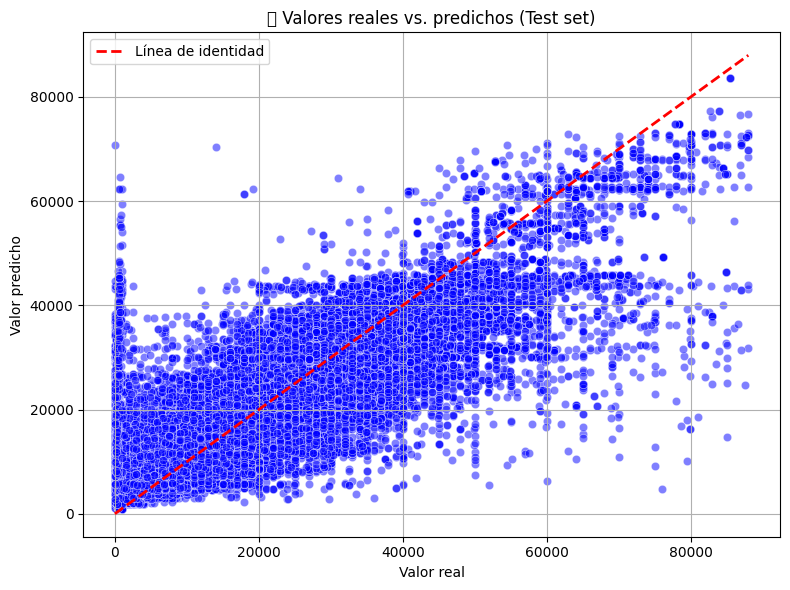

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_test_tuned, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Línea de identidad')
plt.title('📈 Valores reales vs. predichos (Test set)')
plt.xlabel('Valor real')
plt.ylabel('Valor predicho')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


 1. year
 2. cylinders
 3. odometer
 4. manufacturer_alfa-romeo
 5. manufacturer_aston-martin
 6. manufacturer_audi
 7. manufacturer_bmw
 8. manufacturer_buick
 9. manufacturer_cadillac
10. manufacturer_chevrolet
11. manufacturer_chrysler
12. manufacturer_datsun
13. manufacturer_dodge
14. manufacturer_ferrari
15. manufacturer_fiat
16. manufacturer_ford
17. manufacturer_gmc
18. manufacturer_harley-davidson
19. manufacturer_honda
20. manufacturer_hyundai
21. manufacturer_infiniti
22. manufacturer_jaguar
23. manufacturer_jeep
24. manufacturer_kia
25. manufacturer_land rover
26. manufacturer_lexus
27. manufacturer_lincoln
28. manufacturer_mazda
29. manufacturer_mercedes-benz
30. manufacturer_mercury
31. manufacturer_mini
32. manufacturer_mitsubishi
33. manufacturer_morgan
34. manufacturer_nissan
35. manufacturer_pontiac
36. manufacturer_porsche
37. manufacturer_ram
38. manufacturer_rover
39. manufacturer_saturn
40. manufacturer_subaru
41. manufacturer_tesla
42. manufacturer_toyota
43. manu

<ipython-input-26-10e609ad64be>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
<ipython-input-26-10e609ad64be>:23: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


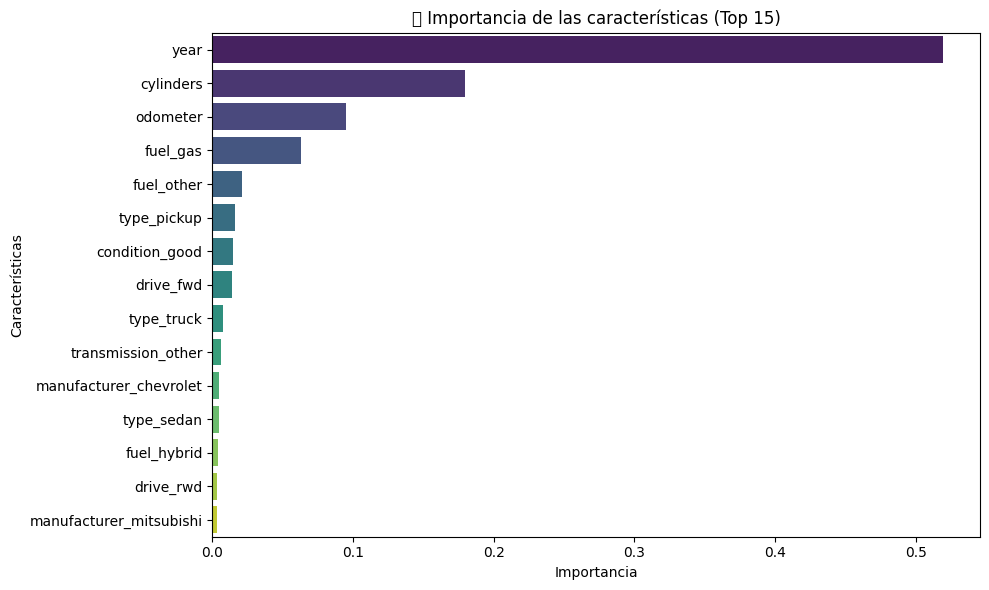

In [26]:
# Lista de variables consideradas por el modelo
variables_modelo = list(X_train.columns)

# Mostrarlas
for i, var in enumerate(variables_modelo, 1):
    print(f"{i:2d}. {var}")


# Importancia de características
importances = rf_tuned.feature_importances_
features = X_train.columns

# Crear un DataFrame con la importancia
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).head(15)  # Top 15

# Gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
plt.title('🌟 Importancia de las características (Top 15)')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.tight_layout()
plt.show()


<ipython-input-25-276d41362823>:8: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


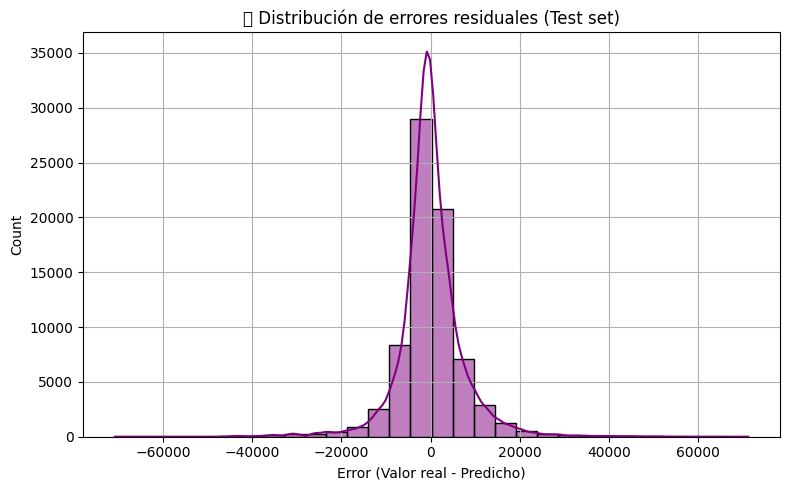

In [25]:
residuals = y_test - y_pred_test_tuned

plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True, color='purple')
plt.title('📊 Distribución de errores residuales (Test set)')
plt.xlabel('Error (Valor real - Predicho)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
import joblib

# Guardar el modelo en un archivo .pkl
joblib.dump(rf_tuned, 'modelo_rf_tuned_1.pkl')

import pickle

# Guardar el modelo en un archivo .pkl
with open('modelo_rf_tuned_2.pkl', 'wb') as f:
    pickle.dump(rf_tuned, f)